In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

torch.manual_seed(0)
np.random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),

    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print("Dataset size:", len(train_dataset))


100%|██████████| 170M/170M [00:03<00:00, 48.1MB/s]


Dataset size: 50000


In [3]:
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 10
sample_dir = "gan_samples"
os.makedirs(sample_dir, exist_ok=True)


In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

generator = Generator(latent_dim).to(device)


In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ZeroPad2d((0, 1, 0, 1)),
            nn.BatchNorm2d(64, momentum=0.82),
            nn.LeakyReLU(0.25),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.82),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=0.8),
            nn.LeakyReLU(0.25),
            nn.Dropout(0.25),

            nn.Flatten(),
            nn.Linear(256 * 5 * 5, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

discriminator = Discriminator().to(device)


In [6]:
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

def denormalize(img_tensor):
    img = img_tensor * 0.5 + 0.5
    return torch.clamp(img, 0, 1)


Epoch 1/10: 100%|██████████| 1563/1563 [00:32<00:00, 47.95it/s, D_loss=0.6636, G_loss=1.1477]


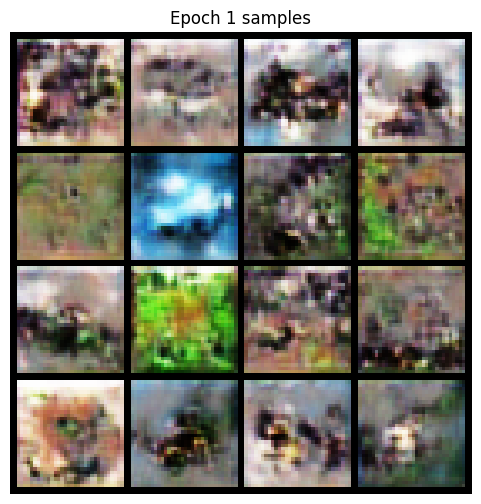

Epoch 2/10: 100%|██████████| 1563/1563 [00:30<00:00, 50.96it/s, D_loss=0.6339, G_loss=1.4186]


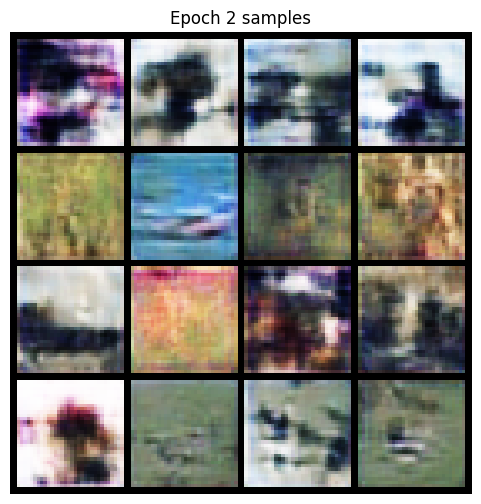

Epoch 3/10: 100%|██████████| 1563/1563 [00:32<00:00, 47.83it/s, D_loss=0.3509, G_loss=1.7941]


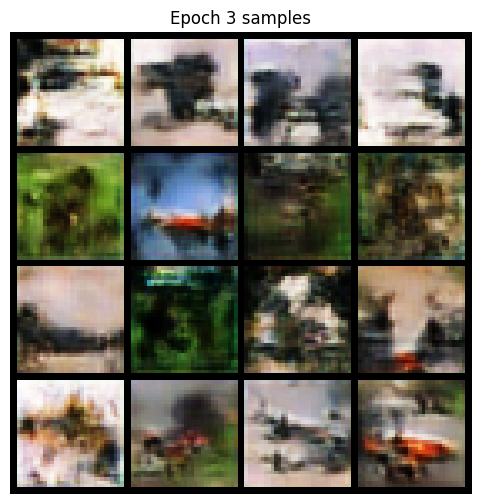

Epoch 4/10: 100%|██████████| 1563/1563 [00:32<00:00, 48.54it/s, D_loss=0.4616, G_loss=1.1265]


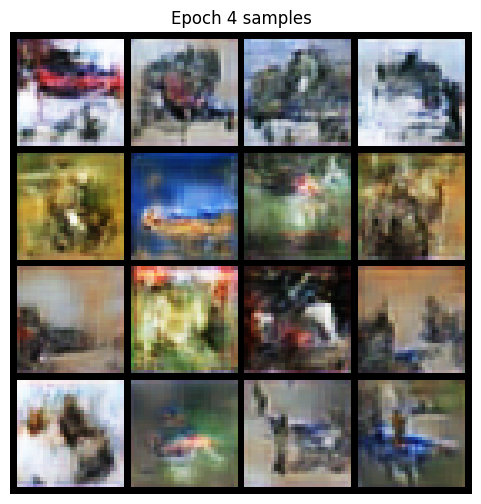

Epoch 5/10: 100%|██████████| 1563/1563 [00:31<00:00, 48.95it/s, D_loss=0.6437, G_loss=0.8964]


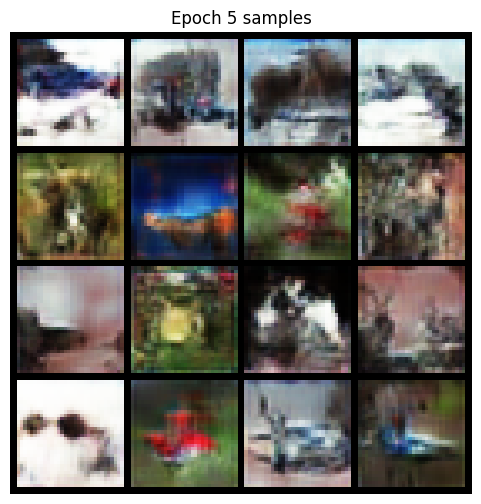

Epoch 6/10: 100%|██████████| 1563/1563 [00:32<00:00, 48.48it/s, D_loss=0.5578, G_loss=1.6796]


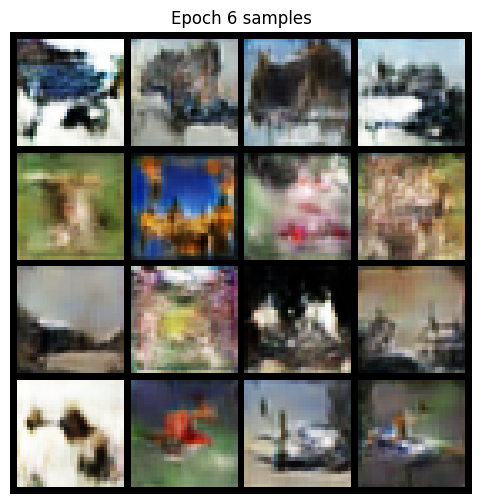

Epoch 7/10: 100%|██████████| 1563/1563 [00:31<00:00, 49.44it/s, D_loss=0.8121, G_loss=1.5712]


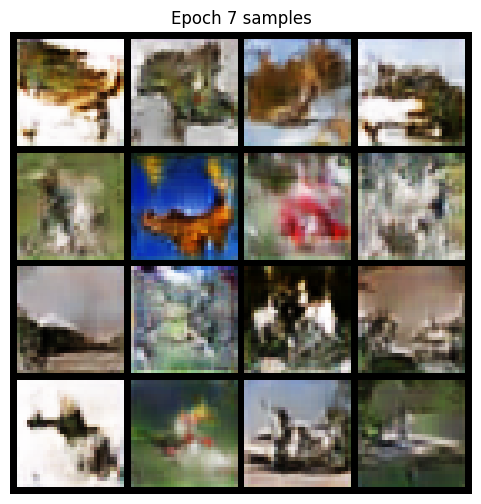

Epoch 8/10: 100%|██████████| 1563/1563 [00:32<00:00, 48.20it/s, D_loss=0.4777, G_loss=1.3331]


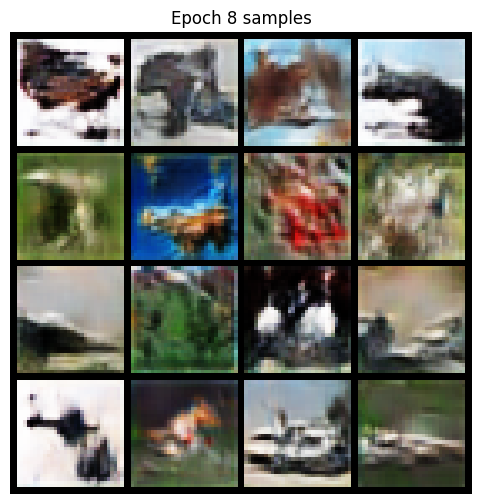

Epoch 9/10: 100%|██████████| 1563/1563 [00:32<00:00, 48.72it/s, D_loss=0.6786, G_loss=1.1501]


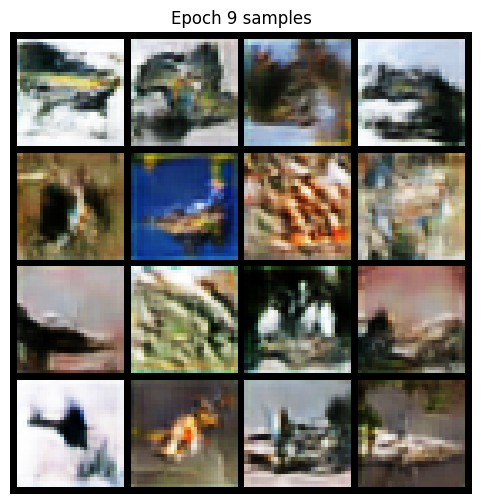

Epoch 10/10: 100%|██████████| 1563/1563 [00:33<00:00, 46.69it/s, D_loss=0.6271, G_loss=1.3390]


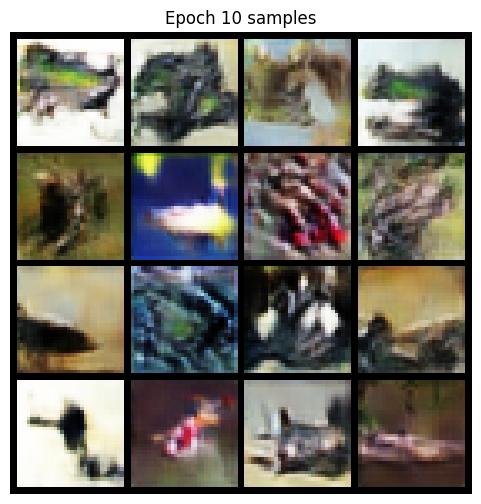

In [7]:
fixed_z = torch.randn(16, latent_dim, device=device)
for epoch in range(num_epochs):
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, (imgs, _) in pbar:
        real_images = imgs.to(device)

        batch_size = real_images.size(0)
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        optimizer_D.zero_grad()
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_images = generator(z)

        real_loss = adversarial_loss(discriminator(real_images), valid)
        fake_loss = adversarial_loss(discriminator(fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        gen_images = generator(z)
        g_loss = adversarial_loss(discriminator(gen_images), valid)
        g_loss.backward()
        optimizer_G.step()

        if (i + 1) % 100 == 0:
            pbar.set_postfix({
                "D_loss": f"{d_loss.item():.4f}",
                "G_loss": f"{g_loss.item():.4f}"
            })

    with torch.no_grad():
        sample_imgs = generator(fixed_z).cpu()
        sample_imgs = denormalize(sample_imgs)
        grid = torchvision.utils.make_grid(sample_imgs, nrow=4)
        np_grid = np.transpose(grid.numpy(), (1, 2, 0))

        plt.figure(figsize=(6,6))
        plt.imshow(np_grid)
        plt.axis("off")
        plt.title(f"Epoch {epoch+1} samples")
        plt.show()

        torchvision.utils.save_image(sample_imgs, os.path.join(sample_dir, f"epoch_{epoch+1}.png"), normalize=False)


Saved model checkpoints: generator.pth, discriminator.pth


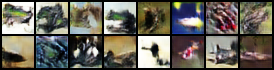

In [8]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")
print("Saved model checkpoints: generator.pth, discriminator.pth")

from IPython.display import Image as IPImage
IPImage(filename=os.path.join(sample_dir, f"epoch_{num_epochs}.png"))
